In [1]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [9]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Processing**

In [3]:
filesPath001="/content/drive/My Drive/Datasets/PS_20174392719_1491204439457_log.csv"
finInfo = pd.read_csv(filesPath001)
finInfo.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
finInfo.isnull().values.any()
print(finInfo.dtypes)

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [5]:
encoder = LabelEncoder()
typeTransaction = finInfo['type']
nameO = finInfo['nameOrig']
nameD = finInfo['nameDest']
finInfo.drop(columns='step', inplace=True)
finInfo['nameOrig'] = encoder.fit_transform(nameO) 
finInfo['nameDest'] = encoder.fit_transform(nameD) 
finInfo['type'] = encoder.fit_transform(typeTransaction)
finInfo.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [ ]:

Correlation = finInfo.corr()
Correlation.sort_values(by=["isFraud"],ascending=False,inplace=True)
Correlation["isFraud"][1:]

amount            0.076688
isFlaggedFraud    0.044109
type              0.020833
oldbalanceOrg     0.010154
newbalanceDest    0.000535
nameOrig         -0.000464
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
nameDest         -0.021963
Name: isFraud, dtype: float64

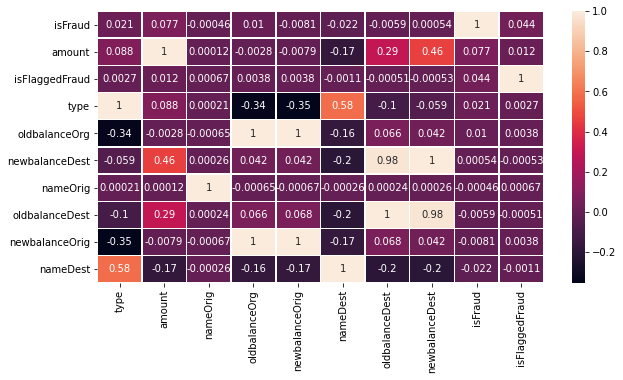

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(Correlation,annot=True, linewidth=0.5)

**KNN with all features**

0.9989831233045506
ROC_AUC_SCORE: 0.9540482691216277


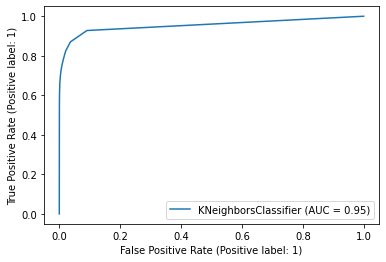

In [14]:
#500 neighbors because 2270 is supposed to be optimal but 1000-2270 crashes runtime by using up all the ram
y = finInfo['isFraud']
X = finInfo.drop(columns=['isFraud'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
knn = KNeighborsClassifier(n_neighbors=500)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))
y_pred_prob = knn.predict_proba(X_test)
print("ROC_AUC_SCORE:",roc_auc_score(y_test,y_pred_prob[:,1]))
metrics.plot_roc_curve(knn, X_test, y_test)

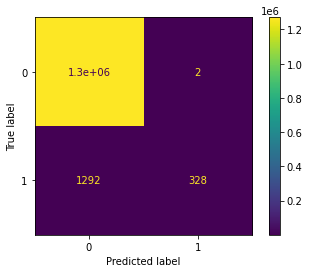

In [15]:
plot_confusion_matrix(knn, X_test, y_test) 

**KNN with features selected**

In [6]:
y = finInfo['isFraud']
X = finInfo.drop(['isFraud','newbalanceDest','nameOrig','oldbalanceDest','newbalanceOrig'], axis = 1)
X.head()

,type,amount,oldbalanceOrg,nameDest,isFlaggedFraud
0,3,9839.64,170136.0,1662094,0
1,3,1864.28,21249.0,1733924,0
2,4,181.00,181.0,439685,0
3,1,181.00,181.0,391696,0
4,3,11668.14,41554.0,828919,0


In [7]:
#500 neighbors because 2270 is supposed to be optimal but 1000-2270 crashes runtime by using up all the ram
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
knnFeatureExtract = KNeighborsClassifier(n_neighbors=500)
knnFeatureExtract.fit(X_train,y_train)
y_pred = knnFeatureExtract.predict(X_test)

Accuracy: 0.9991261461473419
ROC_AUC_SCORE: 0.9921549790397083


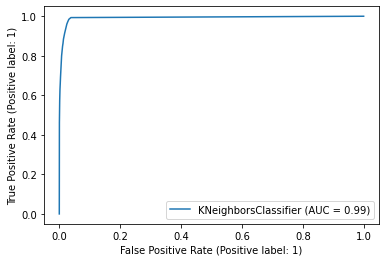

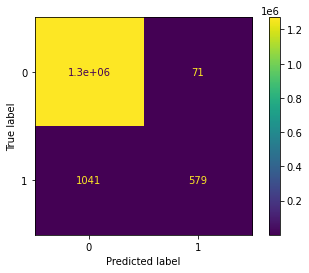

In [12]:
y_pred_prob = knnFeatureExtract.predict_proba(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC_AUC_SCORE:",roc_auc_score(y_test,y_pred_prob[:,1]))
metrics.plot_roc_curve(knnFeatureExtract, X_test, y_test)
plot_confusion_matrix(knnFeatureExtract, X_test, y_test) 

In [ ]:
estimator = LinearRegression()
selector = SequentialFeatureSelector(estimator, n_features_to_select=5, direction='forward')
selector = selector.fit(X_train, y_train)
X_train.iloc[:,selector.support_]
print("Features selected by Sequential forward selection",X_train.iloc[:,selector.support_].columns)

Features selected by Sequential forward selection Index(['type', 'amount', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], dtype='object')


In [ ]:
tree_reg = DecisionTreeRegressor(random_state=20)
tree_reg.fit(X_train,y_train)
imp = tree_reg.feature_importances_

ids = imp.argsort()[::-1][:5]
print("Features selected by decision tree feature importance selection",X_train.iloc[:,ids].columns)

Features selected by decision tree feature importance selection Index(['oldbalanceOrg', 'newbalanceDest', 'amount', 'oldbalanceDest',
       'newbalanceOrig'],
      dtype='object')


In [ ]:
while True:pass